In [1]:
# Importing necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [2]:
# Set parameters
img_size = 299  # InceptionV3 input size
batch_size = 32
epochs = 100

In [3]:
# Set the directories for the dataset
train_dir = "../../src/data/train"
val_dir = "../../src/data/val"
test_dir = "../../src/data/test"

In [5]:
# Create image data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=45,
    zoom_range=[0.8, 1.25],
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.1, 2],
    fill_mode='constant'
)

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
# Create generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    val_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Important for evaluation
)

Found 2770 images belonging to 4 classes.
Found 62 images belonging to 4 classes.
Found 154 images belonging to 4 classes.


In [7]:
# Build the InceptionV3 model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(len(train_generator.class_indices), activation='softmax')(x)

2024-10-08 21:14:04.675763: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-10-08 21:14:04.675800: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-10-08 21:14:04.675821: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-10-08 21:14:04.676821: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-10-08 21:14:04.677219: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


87910968/87910968 [==============================] - 13s 0us/step


In [8]:
# Create the complete model
model = Model(inputs=base_model.input, outputs=predictions)

In [9]:
# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

In [10]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=epochs
)

Epoch 1/100


2024-10-08 21:15:24.143900: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


86/86 [==============================] - ETA: 0s - loss: 1.2362 - accuracy: 0.4810

2024-10-08 21:15:51.838645: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


86/86 [==============================] - 29s 283ms/step - loss: 1.2362 - accuracy: 0.4810 - val_loss: 0.9765 - val_accuracy: 0.6562
Epoch 2/100
86/86 [==============================] - 25s 282ms/step - loss: 0.9591 - accuracy: 0.6373 - val_loss: 0.8789 - val_accuracy: 0.6875
Epoch 3/100
86/86 [==============================] - 24s 278ms/step - loss: 0.9142 - accuracy: 0.6446 - val_loss: 0.8349 - val_accuracy: 0.7188
Epoch 4/100
86/86 [==============================] - 25s 288ms/step - loss: 0.8442 - accuracy: 0.6753 - val_loss: 0.7034 - val_accuracy: 0.7812
Epoch 5/100
86/86 [==============================] - 26s 297ms/step - loss: 0.8163 - accuracy: 0.6822 - val_loss: 0.8015 - val_accuracy: 0.7188
Epoch 6/100
86/86 [==============================] - 26s 304ms/step - loss: 0.7813 - accuracy: 0.7082 - val_loss: 0.8171 - val_accuracy: 0.6875
Epoch 7/100
86/86 [==============================] - 30s 344ms/step - loss: 0.7803 - accuracy: 0.7001 - val_loss: 0.8804 - val_accuracy: 0.6875
Epoc

In [12]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")

5/5 [==============================] - 2s 319ms/step - loss: 0.5094 - accuracy: 0.7987
Test Loss: 0.5094215869903564
Test Accuracy: 0.798701286315918


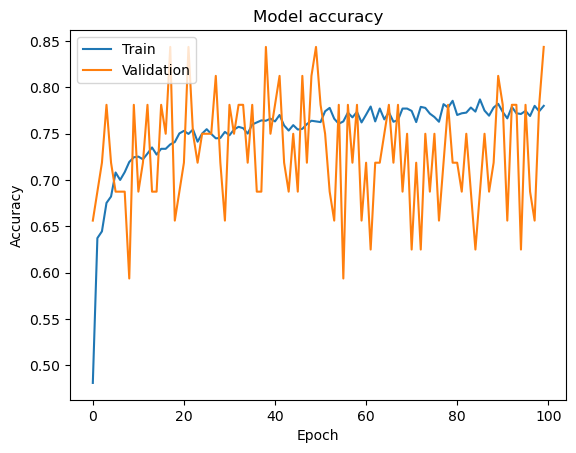

In [13]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

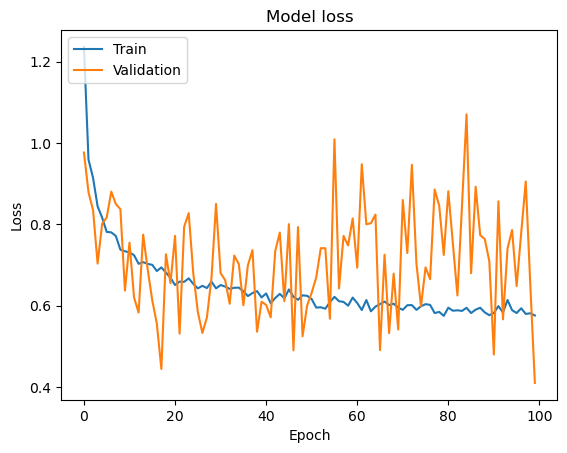

In [14]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()